In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


**Note**: This code is made using help from various sources like udacity and various people's implementation. I'll try to improve upon this code as i learn

## Deep Q-Network Architecture

The network is something like this:

1. `input_size = state_size = 37`
2. 2 linear layers, one with 128 nodes as output and other with 64 nodes as output with relu activation for both
3. A third linear layer with 4 outputs for 4 actions

## Learning algo to use

The algo used in this project will be Q-learning algo with experience relay and fixed Q targets. The optimization of network will be done through `Adam` optimizer

### Hyperparameters used


* `BUFFER_SIZE = int(1e5)` : replay buffer size
* `BATCH_SIZE = 64` : minibatch size
* `GAMMA = 0.99` : discount factor
* `TAU = 1e-3` : for soft update of target parameters
* `LR = 5e-4` : learning rate
* `UPDATE_EVERY = 4` : how often to update the network
* `EPS_DECAY=0.995` : the reduction factor of the epsilon-greedy policy



## Environment Information

The environment we will use is [Unity MLAgents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md)

In [2]:
from unityagents import UnityEnvironment
from dqn_agent import Agent
from collections import deque

import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt

Next, we'll start the environment. To run on a new machine, before running the environment, change the `file_name` parameter to the path where the Unity environment is installed in the machine. 

Here are the various paths for different operating systems:


* Mac: `"path/to/Banana.app"`
* Windows (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
* Windows (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
* Linux (x86): `"path/to/Banana_Linux/Banana.x86"`
* Linux (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
* Linux (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
* Linux (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

The environment has 4 actions:
`0`: walk forward
`1`: walk backward
`2`: turn left
`3`: turn right

State space has 37 dimensions. A reward of +1 will be awarded for collecting yellow banana and -1 for purple banana

In [3]:
env = UnityEnvironment(file_name='/data/Banana_Linux_NoVis/Banana.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Train the agent with DQN

In [5]:
agent = Agent(state_size=37, action_size=4, seed=32, fc1_units=128, fc2_units=64)

In [6]:
save_path = 'checkpoint.pth'
episode_num = 1
def save_model(model, episode_num):
    if model is not None:
        checkpoint = {
            'episode_num': episode_num,
            'state_dict': model.state_dict()
        }
        torch.save(checkpoint, save_path)
        print('\r\tsave episode' + str(episode_num), end='')

def load_model(model):
    if os.path.exists(save_path) and model is not None:
        checkpoint = torch.load(save_path)
        episode_num = checkpoint['episode_num']
        model.load_state_dict(checkpoint['state_dict'])
        print('Loaded episode number: ', episode_num)
        return episode_num
    return 1

episode_num = load_model(agent.qnetwork_local)
print(episode_num)

Loaded episode number:  700
700


In [7]:
def dqn(n_episodes=2000, max_t=100000, eps_start=1., eps_end=.01, eps_decay=.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = (int)(agent.act(state, eps))
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score+=reward
            if done: break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
            save_model(agent.qnetwork_local, i_episode)
        if np.mean(scores_window) >= 15.:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pth')
            break
    return scores

In [9]:
scores = dqn()

Episode 785	Average Score: 15.05
Environment solved in 685 episodes!	Average Score: 15.05


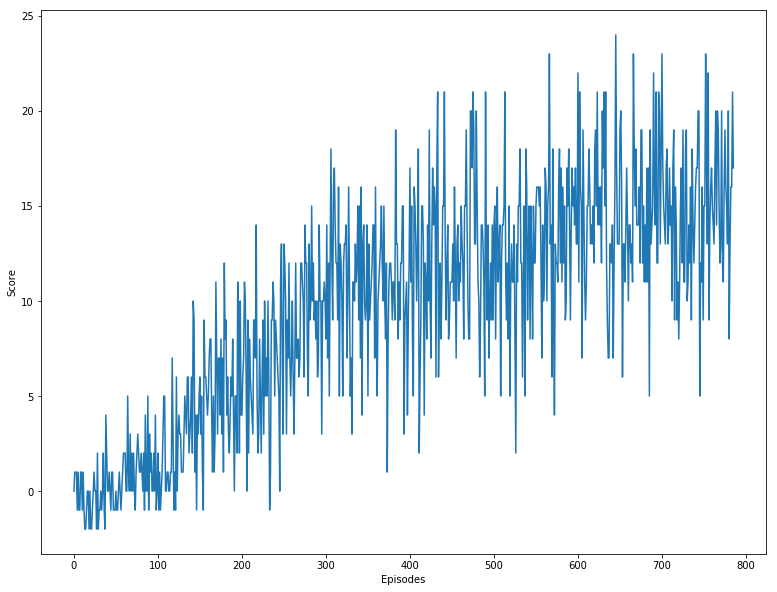

In [10]:
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

## Testing the trained

In [8]:
agent.qnetwork_local.load_state_dict(torch.load('model.pth'))

env_info = env.reset(train_mode=False)[brain_name]

state = env_info.vector_observations[0]
score = 0

while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score+=reward
    state = next_state
    if done: break

print('Score:', score)

Score: 16.0


In [ ]:
env.close()

## Future work to consider:

I'm planning to add following features in this:
* Duelling DQN
* Double DQN
* Prioritized Experienced Replay